In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from scalp_utils import *
import joblib
from IPython.display import clear_output
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
import scipy.stats as sp_stats
plt.style.use('dark_background')
mne.viz.set_browser_backend('qt')

'qt'

In [3]:
subj = ''
y_subj = get_all_y_AH(subjects=[subj])
clear_output()
print(len(y_subj))
print(y_subj.sum())

Extracting EDF parameters from C:\UCLA\416_clean_eog.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


KeyboardInterrupt: 

In [ ]:
subj = '53'
y_subj = get_all_chans_y(subjects=[subj], path='D:\\TLV\\%s_clean_mtl_annot.fif')
clear_output()
print(len(y_subj))
print(y_subj.sum())


In [10]:
feat_eog1 = get_all_feat_eog_with_chan_feat('1', subjects=[subj],  path='C:\\UCLA\\%s_clean_mtl_annot.fif')
clear_output()
feat_eog2 = get_all_feat_eog_with_chan_feat('2', subjects=[subj],  path='C:\\UCLA\\%s_clean_mtl_annot.fif')
clear_output()

In [2]:
subj = '416'
y_AH_dict = joblib.load('y_dict_xgb_AH.pkl')
eog1_dict = joblib.load('eog1_dict_all_24.pkl')
eog2_dict = joblib.load('eog2_dict_all_24.pkl')
y_subj = y_AH_dict[subj]
feat_eog1 = eog1_dict[subj]
feat_eog2 = eog2_dict[subj]

In [3]:
print(len(y_subj))
print(y_subj.sum())

108251
1584.0


In [4]:
subj_feat = pd.concat([feat_eog1, feat_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)

# under sampling non-spikes epochs
subj_feat['y'] = y_subj.astype(int)
feat_0 = subj_feat[subj_feat['y'] == 0].sample(n=int(y_subj.sum()))
feat_1 = subj_feat[subj_feat['y'] == 1].sample(n=int(y_subj.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_under = feat_under['y'].to_numpy()
subj_feat = subj_feat.drop('y', axis=1)
feat_under = feat_under.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(feat_under, y_under, random_state=20)

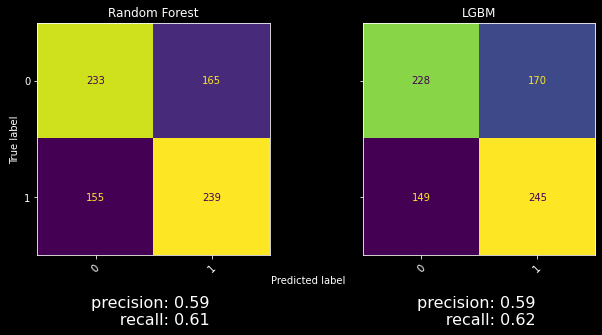

In [5]:
prob=None
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=X_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

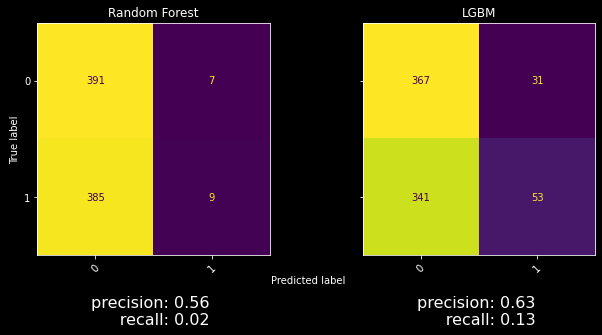

In [6]:
prob=0.8
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [10]:
# features = np.nan_to_num(features[model_lgbm.feature_name_])
# subj_feat = pd.concat([feat_eog1, feat_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)

# y_lgbm = classifiers['LGBM'].predict(subj_feat.iloc[:, 2:])
y_lgbm = classifiers['LGBM'].predict_proba(subj_feat.iloc[:, 2:]).T
y_lgbm = [p > 0.85 for p in y_lgbm[1]]

y_rf = classifiers['Random Forest'].predict_proba(subj_feat.iloc[:, 2:]).T
y_rf = [p > 0.85 for p in y_rf[1]]
y_scalp = np.array(y_lgbm) + np.array(y_rf)
y_scalp[y_scalp == 2] = 1
index_map = map_nan_index('C:\\UCLA\\%s_clean_mtl_annot.fif' % subj, 'RA1')
scalp_onsets = np.where(y_scalp == 1)[0]
scalp_onsets = [index_map[int(x)] / 4 for x in scalp_onsets]
depth_onsets = np.where(y_subj == 1)[0]
depth_onsets = [index_map[int(x)] / 4 for x in depth_onsets]
both = [x for x in scalp_onsets if x in depth_onsets]
raw = mne.io.read_raw('C:\\UCLA\\%s_clean_mtl_annot.fif' % subj)
# all annot
annot = mne.Annotations(scalp_onsets, [0.25] * len(scalp_onsets), ['scalp'] * len(scalp_onsets)).append(depth_onsets, [0.25] * len(depth_onsets), ['depth'] * len(depth_onsets)).append(both, [0.25] * len(both), ['both'] * len(both))
# only depth and both
annot = mne.Annotations(depth_onsets, [0.25] * len(depth_onsets), ['depth'] * len(depth_onsets)).append(both, [0.25] * len(both), ['both'] * len(both))
# only both
# annot = mne.Annotations(both, [0.25] * len(both), ['both'] * len(both))
raw.set_annotations(annot)
# mne.set_bipolar_reference(raw, raw.ch_names[0], raw.ch_names[1], ch_name='bi', drop_refs=False).plot(
#     duration=30, scalings='auto')

raw.crop(tmin=0, tmax=60*60*3).plot(duration=30, scalings='auto')

Opening raw data file C:\UCLA\416_clean_mtl_annot.fif...


C:\repos\spikes_notebooks\scalp_utils.py:99: RuntimeWarning: This filename (C:\UCLA\416_clean_mtl_annot.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(edf)


Isotrak not found
    Range : 0 ... 27542999 =      0.000 ... 27542.999 secs
Ready.
Setting 269876 of 27543000 (0.98%) samples to NaN, retaining 27273124 (99.02%) samples.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


C:\Users\user\AppData\Local\Temp/ipykernel_22320/3905387338.py:18: RuntimeWarning: This filename (C:\UCLA\416_clean_mtl_annot.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw('C:\\UCLA\\%s_clean_mtl_annot.fif' % subj)


Isotrak not found
    Range : 0 ... 27542999 =      0.000 ... 27542.999 secs
Ready.


In [8]:
p = np.where(y_scalp == 1)[0]
[index_map[int(x)] for x in p]

array([   149,    211,    275, ..., 108170, 108188, 108243], dtype=int64)

In [14]:
np.where(y_subj == 1)

(array([  546,   834,   836, ..., 72265, 72266, 72268], dtype=int64),)

In [10]:
print(len(depth_onsets))
print(len(scalp_onsets))
print(len(both))
print(len(y_lgbm))

4364
8152
2455
124607


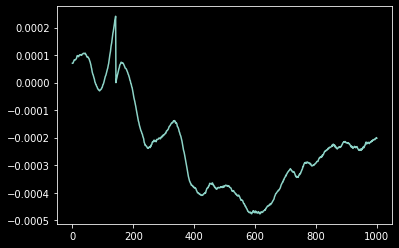

In [21]:
data = raw.copy().crop(tmin=715, tmax=716).get_data()[0]
plt.plot(data)

In [22]:
z_score_grad = stats.zscore(np.ediff1d(data))
np.where(abs(z_score_grad) >10)

(array([142], dtype=int64),)

In [ ]:
def format_raw_night_original(edf, channel, norm='raw', subj=None):
    epochs = []
    window_size = int(sr / 4)
    if '-' in channel and 'REF' not in channel:
        chans = channel.split('-')
        raw = mne.io.read_raw_edf(edf).pick_channels(chans).resample(sr)
        # raw = remove_rem(raw, edf)
        mne.set_bipolar_reference(raw, chans[0], chans[1], ch_name=channel)
        raw_data = raw.get_data()[0]
    else:
        raw_data = mne.io.read_raw_edf(edf).pick_channels([channel]).resample(sr).get_data()[0]

    if norm == 'raw':
        raw_data = (raw_data - raw_data.mean()) / raw_data.std()
    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)

    # Normalization
    epochs = np.array(epochs)
    if norm == 'epochs':
        epochs = (epochs - epochs.mean()) / epochs.std()
    return epochs

In [ ]:
edf = 'C:\\UCLA\\%s_clean_eog.edf' % subj
channel, norm = 'RAH1', 'raw'
